# Completion Trie and metrics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Wikipedia titles, uniform

In [2]:
from mlstatpy.data.wikipedia import download_titles
file_titles = download_titles(country='fr')

In [3]:
from mlstatpy.data.wikipedia import enumerate_titles
list_titles = list(sorted(_ for _ in enumerate_titles(file_titles) if 'A' <= _[0] <= 'Z'))

In [4]:
len(list_titles), list_titles[:5], list_titles[1000000:1000005]

(3045736,
 ['A',
  'A & A',
  'A (Airport Express)',
  'A (Ayumi Hamasaki)',
  "A (Disque d'Ayumi Hamasaki)"],
 ['Festival du cinéma de Brive - Rencontres du moyen métrage',
  'Festival du cinéma de Brive - Rencontres européennes du moyen métrage',
  'Festival du cinéma de Venise',
  'Festival du cinéma espagnol de Malaga',
  'Festival du cinéma européen de Lille'])

In [5]:
from mlstatpy.nlp.completion import CompletionTrieNode

def gain_dynamique_moyen_par_mot(queries, weights):
    per = list(zip(weights, queries))
    total = sum(weights) * 1.0 
    res = []
    trie = CompletionTrieNode.build([(None, q) for _, q in per])
    trie.precompute_stat()
    trie.update_stat_dynamic()
    wks = [(w, p, len(w)-trie.min_keystroke0(w)[0]) for p, w in per]
    wks_dyn = [(w, p, len(w)-trie.min_dynamic_keystroke(w)[0]) for p, w in per]
    wks_dyn2 = [(w, p, len(w)-trie.min_dynamic_keystroke2(w)[0]) for p, w in per]
    gain = sum( g*p/total for w, p, g in wks)
    gain_dyn = sum( g*p/total for w, p, g in wks_dyn)
    gain_dyn2 = sum( g*p/total for w, p, g in wks_dyn2)
    ave_length = sum( len(w) * p / total for p, w in per)
    return gain, gain_dyn, gain_dyn2, ave_length

In [76]:
import time, random, pandas

def benchmark(sizes):
    print("time", 0)
    allres = []
    for size in sizes:
        begin = time.clock()
        if size is None:
            size = len(list_titles)
            spl = list_titles
        else:
            spl = random.sample(list_titles, size)
        spl.sort()
        res = gain_dynamique_moyen_par_mot(spl, [1.0] * len(spl))
        dt = time.clock() - begin
        print("time: {0}s - nb={1}".format(dt, len(spl)), "gain", tuple(_/res[-1] for _ in res))
        allres.append((size, dt) + res)
        # with open("sample%d.txt" % len(spl), "w", encoding="utf-8") as f:
        #    f.write("\n".join(spl))
    df = pandas.DataFrame(allres, columns="size time mks mks' mks\" ave_len".split())    
    for c in "mks mks' mks\"".split():
        df["%" + c] = df[c] / df["ave_len"]
        df[c + "/mks"] = df[c] / df["mks"]    
    return df
                  
df = benchmark([200, 500, 800, 1000, 2000, 5000, 8000, 10000, 20000])
df.tail(n=2)

time 0
time: 0.229318067328677s - nb=200 gain (0.8281050752359091, 0.8281050752359091, 0.8281050752359091, 1.0)
time: 0.5236743096470491s - nb=500 gain (0.798661174047373, 0.798661174047373, 0.798661174047373, 1.0)
time: 0.8249052146684335s - nb=800 gain (0.7861963580797157, 0.7861963580797157, 0.7861963580797157, 1.0)
time: 1.0142825864400038s - nb=1000 gain (0.7788042083654089, 0.7788042083654089, 0.7788042083654089, 1.0)
time: 4.90707659202144s - nb=2000 gain (0.7496873371547687, 0.7496873371547687, 0.7496873371547687, 1.0)
time: 6.267216805035332s - nb=5000 gain (0.7146076475392082, 0.7146076475392082, 0.7146076475392082, 1.0)
time: 10.61296795045564s - nb=8000 gain (0.6976982687340292, 0.6976982687340292, 0.6976982687340292, 1.0)
time: 12.317359164776917s - nb=10000 gain (0.6904127829560583, 0.6904381943667984, 0.6904381943667984, 1.0)
time: 23.535995761280446s - nb=20000 gain (0.6545138268034985, 0.6546492084007969, 0.6546492084007969, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
7,10000,12.317359,13.58470,13.5852,13.5852,19.6762,0.690413,1.0,0.690438,1.000037,0.690438,1.000037
8,20000,23.535996,12.81165,12.8143,12.8143,19.5743,0.654514,1.0,0.654649,1.000207,0.654649,1.000207


c:\python35_x64\lib\site-packages\matplotlib\axes\_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=50000.0, right=50000.0
  'left=%s, right=%s') % (left, right))


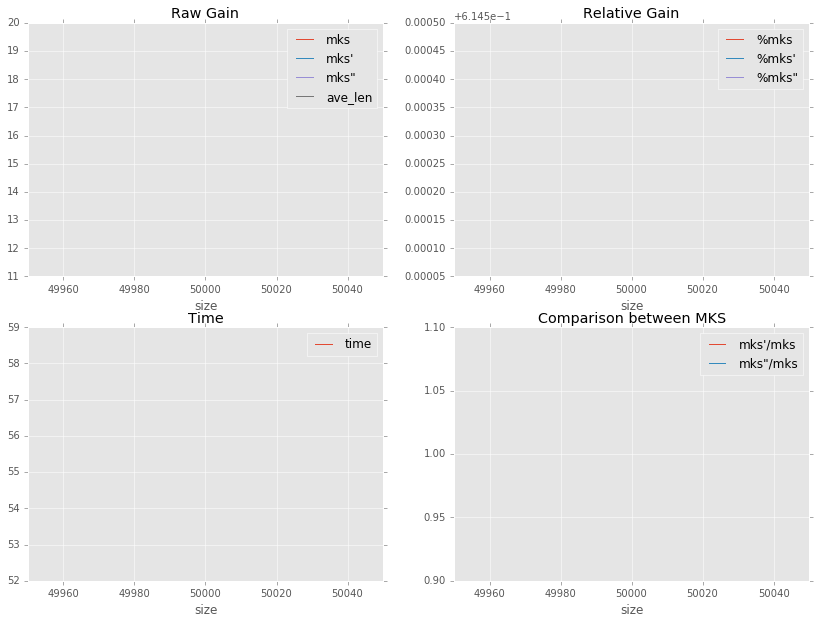

In [77]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 2, figsize=(14,10))
df2.plot(x="size", y="time", ax=ax[1,0])
df2.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
df2.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
df2.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")

## Wikipedia titles, uniform, longer test

In [78]:
df2 = benchmark([50000])
df2.tail(n=2)

time 0
time: 56.074297331300386s - nb=50000 gain (0.6152529671383744, 0.6154993554033411, 0.6154993554033411, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,56.074297,12.03596,12.04078,12.04078,19.56262,0.615253,1.0,0.615499,1.0004,0.615499,1.0004


In [74]:
df2 = benchmark([50000, 100000, 200000, 500000, 500000,, 1000000, 2000000, None])
df2.tail(n=2)

time 0
time: 55.70208455031161s - nb=50000 gain (0.6145525200960573, 0.614978613394102, 0.6149837347077803, 1.0)


,size,time,mks,mks',"mks""",ave_len,%mks,mks/mks,%mks',mks'/mks,"%mks""","mks""/mks"
0,50000,55.702085,11.9999,12.00822,12.00832,19.52624,0.614553,1.0,0.614979,1.000693,0.614984,1.000702


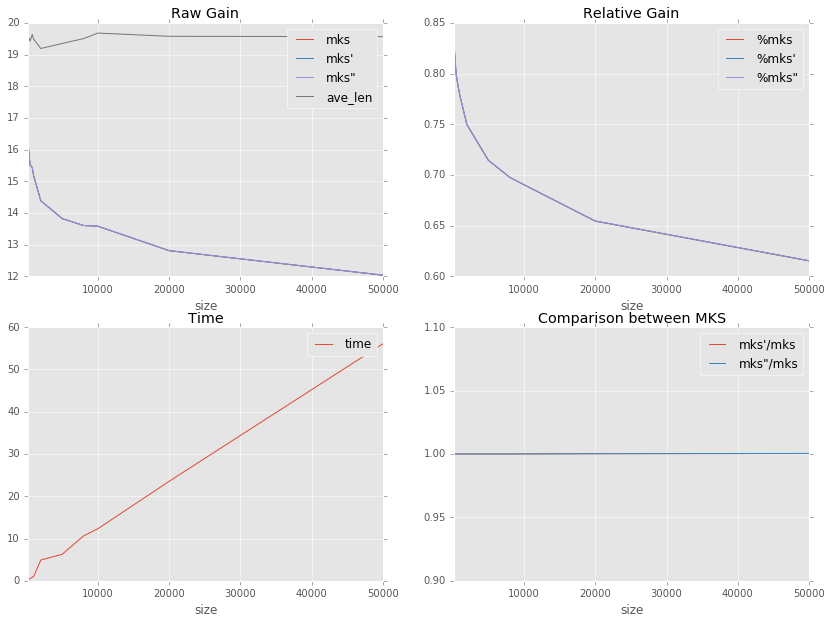

In [79]:
dfall = pandas.concat([df, df2])
f, ax = plt.subplots(2, 2, figsize=(14,10))
dfall.plot(x="size", y="time", ax=ax[1,0])
dfall.plot(x="size", y=["mks", "mks'", "mks\"", "ave_len"], ax=ax[0,0])
dfall.plot(x="size", y=["%mks", "%mks'", "%mks\""], ax=ax[0,1])
dfall.plot(x="size", y=["mks'/mks", "mks\"/mks"], ax=ax[1,1])
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
ax[1,1].set_ylim([0.9, 1.1])
ax[0,0].set_title("Raw Gain")
ax[0,1].set_title("Relative Gain")
ax[1,0].set_title("Time")
ax[1,1].set_title("Comparison between MKS")